In [1]:
import sys
import os
import tqdm
sys.path.append(os.path.abspath("../src"))
sys.path.append(os.path.abspath("./convex_hull"))

In [2]:
"""
Validation loss: 2.8789, trained on ~59.7B FineWeb-Edu tokens.
This is a base model and can frequently hallucinate.
"""

import json

from time import time

import torch
import torch.nn.functional as F
import tiktoken
from torch import nn

from safetensors import safe_open

from model_550m import FlashSTU, FlashSTUConfig, get_spectral_filters


CHECKPOINT_PATH = "../models/model_step-114000.safetensors"
CONFIG_PATH = "../models/config_2-7b.json"

/home/ds6237/.conda/envs/torch-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def apply_compile(model: nn.Module) -> None:
    """
    Apply torch.compile to each layer. This makes compilation efficient
    due to repeated structure. Alternatively, one can just compile the whole model.
    """
    print(f"Compiling each {model.__class__.__name__} layer with torch.compile...")
    start = time.perf_counter()
    for idx, layer in model.layers.named_children():
        compiled_layer = torch.compile(layer, mode="max-autotune", fullgraph=True)
        model.layers.register_module(idx, compiled_layer)
    end = time.perf_counter()
    print(f"Finished compiling each {model.__class__.__name__} layer in {end - start:.4f} seconds.")


def load_stu_model(config_path: str, checkpoint_path: str, device: torch.device):
    with open(config_path, "r") as f:
        config_data = json.load(f)

    dim = config_data["dim"]
    num_heads = config_data["num_heads"]
    num_layers = config_data["num_layers"]
    num_eigh = config_data["num_eigh"]
    seq_len = config_data["seq_len"]
    use_hankel_L = config_data["use_hankel_L"]
    window_size = config_data["window_size"]
    vocab_size = config_data["vocab_size"]
    mlp_scale = config_data["mlp_scale"]
    bias = config_data["bias"]
    dropout = config_data["dropout"]
    softcap = config_data["softcap"]
    theta = config_data["theta"]
    torch_compile = config_data["torch_compile"]
    torch_dtype = getattr(torch, config_data["torch_dtype"])

    model_config = FlashSTUConfig(
        dim=dim,
        num_heads=num_heads,
        num_layers=num_layers,
        seq_len=seq_len,
        window_size=window_size,
        vocab_size=vocab_size,
        mlp_scale=mlp_scale,
        bias=bias,
        dropout=dropout,
        softcap=softcap,
        theta=theta,
        torch_dtype=torch_dtype,
    )

    spectral_filters = get_spectral_filters(seq_len, num_eigh, use_hankel_L, device, torch_dtype)
    model = FlashSTU(model_config, spectral_filters)
    model = model.to(device=device, dtype=torch_dtype)

    print(f"Loading checkpoint from {checkpoint_path}...")
    state_dict = {}
    start_time = time()

    if checkpoint_path.endswith(".safetensors"):
        with safe_open(checkpoint_path, framework="pt", device=device.type) as f:
            for k in f.keys():
                state_dict[k] = f.get_tensor(k)
    elif checkpoint_path.endswith(".pt"):
        state_dict = torch.load(checkpoint_path, map_location="cpu")
    else:
        raise ValueError(f"Unsupported checkpoint format: {checkpoint_path}")
    print(f"Checkpoint loaded in {time() - start_time:.2f} seconds.")

    model.load_state_dict(state_dict, strict=True)
    print("Model weights loaded successfully!")

    if torch_compile:
        model = apply_compile(model)

    model.eval()

    return model, config_data


In [4]:
def generate_text(
    model,
    tokenizer,
    prompt,
    num_return_sequences=1,
    max_length=512,
    device="cuda",
    temperature=1.0,
    top_k=50,
    cache = True
):
    """
    Generate text from the given prompt using top-k sampling.

    Args:
        model: The FlashSTU model instance.
        tokenizer: The tokenizer used for encoding/decoding.
        prompt (str): Input prompt text.
        num_return_sequences (int): How many sequences to return.
        max_length (int): Maximum length of generated tokens.
        device: torch device.
        temperature (float): Sampling temperature. Higher = more random.
        top_k (int): Top-K sampling parameter.

    Returns:
        list[str]: A list of generated text sequences.
    """
    model.eval()

    # Encode prompt tokens.
    tokens = torch.tensor(
        [tokenizer.encode(prompt, allowed_special={"<|endoftext|>"})],
        device=device,
    )
    seq_len = tokens.shape[1]
    tokens = tokens.repeat(num_return_sequences, 1)
    
    input_pos = torch.arange(seq_len, device=device)

    
    sample_rng = torch.Generator(device=device)
    sample_rng.manual_seed(1746)

    eos_token_id = tokenizer.encode(
        "<|endoftext|>", allowed_special={"<|endoftext|>"}
    )[0]
    cur_token = seq_len
    with torch.no_grad():
        for idx in tqdm.tqdm(range(max_length - tokens.size(1))):
            with torch.amp.autocast(device_type="cuda", dtype=torch.bfloat16):
                # Fwd pass. Inspect logits here.
                if not cache:
                    logits = model(tokens)
                elif idx != 0:
                    logits = model(tokens[:, -1:], input_pos = input_pos)     # shape: [batch, 1, vocab]
                else:
                    logits = model(tokens, input_pos = input_pos)     # shape: [batch, seq, vocab]
                logits = logits[:, -1, :]  # last token logits

                # Apply temperature scaling.
                if temperature > 0:
                    logits = logits / temperature

            # Compute probabilities.
            probs = F.softmax(logits, dim=-1)

            # Top-K sampling.
            top_k_probs, top_k_indices = torch.topk(probs, top_k, dim=-1)
            ix = torch.multinomial(top_k_probs, 1, generator=sample_rng)
            next_token = torch.gather(top_k_indices, -1, ix)

            # Append next token.
            tokens = torch.cat((tokens, next_token), dim=1)
            input_pos = torch.tensor([cur_token]).to(device)
            cur_token +=1 
            # Stop if EOS token is generated.
            # if (next_token == eos_token_id).any():
                # break

    # Decode all sequences.
    generated_sequences = []
    for i in range(num_return_sequences):
        decoded = tokenizer.decode(tokens[i].tolist())
        generated_sequences.append(decoded)

    return generated_sequences

In [5]:
from tiktoken.load import load_tiktoken_bpe
bpe_path = "../models/o200k_base.tiktoken"
bpe_dict = load_tiktoken_bpe(bpe_path)

tokenizer = tiktoken.Encoding(
    name="o200k_base",  # Name of the encoding
    pat_str=r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+""",
    mergeable_ranks=bpe_dict,
    special_tokens={
        "<|endoftext|>": 199999,  # Custom special token example (modify as needed)
        "<|endofprompt|>": 200018,
    }
)


In [6]:
device = torch.device("cuda")

# Load model and config.
model, config_data = load_stu_model(CONFIG_PATH, CHECKPOINT_PATH, device)
# tokenizer = tiktoken.get_encoding("o200k_base") #need to cache this for offline



Model Parameter Count: 550.31M



/home/ds6237/.conda/envs/torch-env/lib/python3.12/site-packages/torch/nn/modules/module.py:1326: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/aten/src/ATen/native/Copy.cpp:308.)
  return t.to(


Loading checkpoint from ../models/model_step-114000.safetensors...
Checkpoint loaded in 0.22 seconds.
Model weights loaded successfully!


In [7]:
from torch.amp import autocast
from torch.nn import CrossEntropyLoss
import tqdm 

from dataloader import DataLoader

val_loader = DataLoader(
    bsz=1,
    seq_len= 128,
    dataset='../fineweb-edu', 
    split="val", 
    main_process=True,
)

def evaluate(model, val_steps = 5):
    loss_fn = CrossEntropyLoss()
    val_loss = 0.0
    torch_dtype = getattr(torch, 'bfloat16')
    # val_steps = 5 # Abitrarily set to reduce long evaluations, >20 typically used
    model.eval()
    val_loader.reset()
    with torch.no_grad():
        for i, batch in tqdm.tqdm(zip(range(val_steps), val_loader, strict=False)):
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            if torch_dtype != torch.float32:
                with autocast(device_type=device.type, dtype=torch_dtype, cache_enabled=True):
                    preds = model(inputs)
            else:
                preds = model(inputs)

            loss = loss_fn(preds.flatten(0, 1), targets.flatten(0, 1))
            loss = loss / val_steps
            val_loss += loss.detach().float()
    return(val_loss)

2025-04-02 02:05:59,437 - INFO - Found 1 shards for split val


In [8]:
# Collect prompt(s) from user.
# prompts = []
# while True:
#     prompt = input("Enter a prompt (press enter with no text to finish): ")
#     if not prompt:
#         break
#     prompts.append(prompt.strip())

#     if len(prompts) == 0:
#         print("No prompts provided. Exiting.")
#         break

prompts = ['Harry potter is famous for']

# -------------------------------------------------------------------
# BASE SETTINGS:
BASE_TEMPERATURE = 0.7  # Increase for more randomness.
BASE_TOP_K = 50         # Limit sampling to the top k tokens.
MAX_LENGTH = 1000        # Maximum number of tokens to generate.
# -------------------------------------------------------------------
def generate_and_time(model, prompts, cache = True):
    total_tokens = 0
    start_time = time()
    
    for i, prompt in enumerate(prompts, 1):
        print(f"Generating text for prompt {i}: {prompt}")
        if cache:
            model.setup_caches(batch_size = 1)
        if not cache and model.caches_are_enabled():
            model.reset_caches()
            
        generated_texts = generate_text(
            model,
            tokenizer,
            prompt,
            num_return_sequences=1,
            max_length=MAX_LENGTH,
            device=device,
            temperature=BASE_TEMPERATURE,
            top_k=BASE_TOP_K,
            cache = cache
        )
        for gen_text in generated_texts:
            print(f"\nPrompt: {prompt}")
            print(f"Generated Text: {gen_text}\n")
            total_tokens += len(
                tokenizer.encode(gen_text, allowed_special={"<|endoftext|>"})
            )
        
        if cache:
            model.reset_caches()
    
    end_time = time()
    tokens_per_second = total_tokens / (end_time - start_time)
    print(f"Tokens per second: {tokens_per_second:.2f}")
generate_and_time(model, prompts, True)

#note that when stu is entirely removed, the speed is 145.89 it.s

Generating text for prompt 1: Harry potter is famous for


100%|██████████| 994/994 [00:13<00:00, 71.19it/s]


Prompt: Harry potter is famous for
Generated Text: Harry potter is famous for his potter's wheel, which is a simple machine in which the potter can draw the potter's wheel and then turn the potter's wheel to turn the potter's wheel to make the potter's wheel turn. However, Harry potter is also famous for his pottery which is made of clay, clay tiles, and clay tile. The process is a very complicated process that requires great skill and imagination.
Potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, potter's wheel, po

In [9]:
evaluate(model, val_steps = 50)

50it [00:04, 11.63it/s]


tensor(3.3545, device='cuda:0')

In [10]:
from full_fast_stu import FullFastSTU
# from full_fast_accel import FullFastSTU
import copy

stu_before = []
stu_after = []

In [11]:
for idx in range(0, 12, 2):
    stu_layer = copy.deepcopy(model.layers[idx].stu)
    fast_layer = FullFastSTU(stu_layer.cuda(), "../experiments/convex_hull/fit_filters_205/250_phi_lds_float32.pt").cuda()
    model.layers[idx].stu = fast_layer

    stu_before.append(stu_layer)
    stu_after.append(fast_layer)


/home/ds6237/stu_distill/experiments/convex_hull/full_fast_stu.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=to

In [12]:
evaluate(model, val_steps = 50)

50it [00:05,  8.44it/s]


tensor(3.3552, device='cuda:0')

In [14]:
_ = generate_and_time(model, prompts, cache = True)

Generating text for prompt 1: Harry potter is famous for


100%|██████████| 994/994 [00:11<00:00, 89.60it/s]


Prompt: Harry potter is famous for
Generated Text: Harry potter is famous for his potter's wheel, which is a simple machine in which the potter can draw the potter's wheel and then turn the potter's wheel to turn the potter's wheel to make the potter's wheel turn. However, Harry potter is also famous for his pottery which is made of clay, clay tiles, and clay tile. The term potter's wheel was also used to describe the "first potter" and the first potter's wheel to have a handle.
Early potters, such as Joseph and David, did not have a handle. Instead, they used a long handle to turn the handle of the potter's wheel to make the potter's wheel turn. These pots were used for making clay pots and other types of pottery. Potters used the handle to turn the handle of the potter's wheel to make the potter's wheel turn. Potters used the handle to turn the potter's wheel by turning the handle and turning the potter's wheel by turning the handle. This is sometimes called the "first potter's whee

In [14]:
generate_and_time(model, prompts, cache = False)

Generating text for prompt 1: Harry potter is famous for


  7%|▋         | 69/994 [00:05<01:14, 12.48it/s]

KeyboardInterrupt



In [15]:

import torch.nn.functional as F
gaps = []
with torch.no_grad():
    for i in range(6):
        x = torch.randn(1,100,896).cuda()
        input_pos = torch.arange(100, device=device)
        
        stu_out = stu_before[i](x.bfloat16(), input_pos)
        lds_out = stu_after[i](x.bfloat16(), input_pos)
        print(F.l1_loss(stu_out, lds_out))
        gaps.append((stu_out - lds_out).abs().cpu().detach().float().flatten())
        #F1 of approx 0.005 between stu with lds filters and lds. That's pretty high error

tensor(0.0006, device='cuda:0', dtype=torch.bfloat16)
tensor(0.0021, device='cuda:0', dtype=torch.bfloat16)
tensor(0.0037, device='cuda:0', dtype=torch.bfloat16)
tensor(0.0045, device='cuda:0', dtype=torch.bfloat16)
tensor(0.0040, device='cuda:0', dtype=torch.bfloat16)
tensor(0.0042, device='cuda:0', dtype=torch.bfloat16)


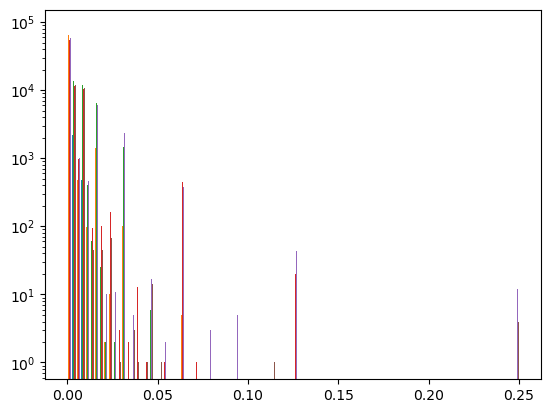

In [16]:
import matplotlib.pyplot as plt

_ = plt.hist(gaps, bins = 100, log = True)
# plt.xscale('log')
plt.show()